## Import core libraries

In [137]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

In [138]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

In [139]:
from tqdm import tqdm

## EDA

**Clearify path**

In [140]:
TRAIN_PATH = "../../dataset"        # train + validation
TEST_PATH  = "../../Test image"

In [141]:
KHMER_DIGITS = {
    0: "០", 1: "១", 2: "២", 3: "៣", 4: "៤",
    5: "៥", 6: "៦", 7: "៧", 8: "៨", 9: "៩"
}

In [142]:
classes = sorted(os.listdir(TRAIN_PATH))
print("Classes:", classes)
print("Number of classes:", len(classes))

Classes: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
Number of classes: 10


In [143]:
class_counts = []
total_images = 0

for cls in classes:
    count = len(os.listdir(os.path.join(TRAIN_PATH, cls)))
    class_counts.append(count)
    total_images += count
    print(f"Class {cls}: {count} images")

print("Total images:", total_images)

Class 0: 300 images
Class 1: 300 images
Class 2: 300 images
Class 3: 300 images
Class 4: 300 images
Class 5: 300 images
Class 6: 300 images
Class 7: 300 images
Class 8: 300 images
Class 9: 300 images
Total images: 3000


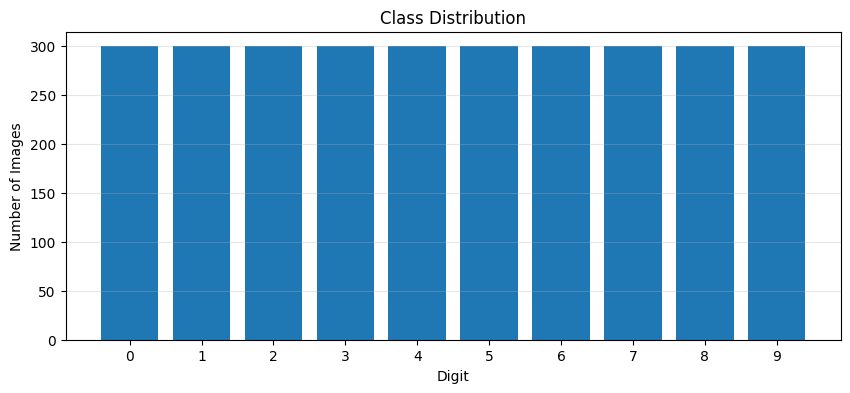

In [144]:
plt.figure(figsize=(10, 4))
plt.bar(classes, class_counts)
plt.title("Class Distribution")
plt.xlabel("Digit")
plt.ylabel("Number of Images")
plt.grid(axis="y", alpha=0.3)
plt.show()


## Inspect raw image statistics

Shape: (222, 170)
Min: 0 Max: 255


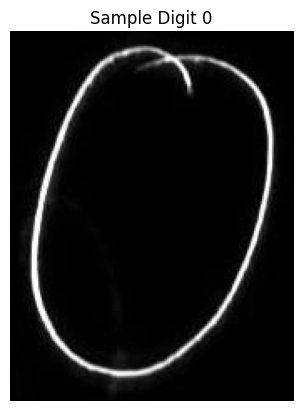

In [145]:
sample_cls = classes[0]
sample_img_path = os.path.join(
    TRAIN_PATH, sample_cls, os.listdir(os.path.join(TRAIN_PATH, sample_cls))[0]
)

img = plt.imread(sample_img_path)

print("Shape:", img.shape)
print("Min:", img.min(), "Max:", img.max())

plt.imshow(img, cmap="gray")
plt.title(f"Sample Digit {sample_cls}")
plt.axis("off")
plt.show()


In [146]:
dims = Counter()

for cls in classes:
    for f in os.listdir(os.path.join(TRAIN_PATH, cls)):
        img = plt.imread(os.path.join(TRAIN_PATH, cls, f))
        dims[img.shape] += 1

print("Image dimensions:")
for k, v in dims.items():
    print(k, ":", v)

Image dimensions:
(222, 170) : 1
(64, 64, 4) : 1500
(143, 99) : 1
(176, 124) : 1
(431, 381) : 1
(270, 190) : 1
(122, 98) : 2
(224, 186) : 1
(115, 101) : 1
(126, 90) : 1
(99, 79) : 2
(251, 206) : 1
(162, 123) : 1
(255, 196) : 1
(265, 220) : 1
(157, 117) : 1
(112, 88) : 1
(436, 335) : 1
(106, 71) : 1
(170, 125) : 1
(135, 79) : 1
(260, 222) : 1
(128, 102) : 5
(261, 227) : 1
(110, 88) : 1
(246, 177) : 1
(176, 99) : 1
(148, 112) : 1
(274, 214) : 1
(130, 84) : 1
(130, 93) : 1
(157, 128) : 1
(186, 131) : 1
(267, 243) : 1
(323, 195) : 1
(106, 85) : 1
(255, 133) : 1
(161, 110) : 1
(154, 91) : 1
(201, 156) : 1
(146, 117) : 2
(261, 235) : 1
(188, 145) : 1
(183, 131) : 1
(250, 189) : 1
(290, 232) : 1
(177, 93) : 1
(261, 239) : 1
(134, 96) : 2
(253, 217) : 1
(112, 90) : 2
(246, 228) : 1
(124, 85) : 1
(290, 201) : 1
(108, 74) : 1
(123, 98) : 4
(120, 96) : 3
(121, 97) : 1
(100, 100) : 1
(250, 247) : 1
(162, 109) : 1
(283, 202) : 1
(117, 74) : 1
(249, 201) : 1
(270, 244) : 1
(113, 82) : 1
(177, 113) :

## Preprocessing

In [147]:
class DigitDataset(Dataset):
    def __init__(self, root_dir):
        self.samples = []
        for label in sorted(os.listdir(root_dir)):
            class_dir = os.path.join(root_dir, label)
            for img_name in os.listdir(class_dir):
                self.samples.append(
                    (os.path.join(class_dir, img_name), int(label))
                )

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]

        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (28, 28))
        img = img.astype(np.float32) / 255.0

        img = np.expand_dims(img, axis=0)  # (1, 28, 28)

        return torch.tensor(img), torch.tensor(label)


In [148]:
#Train / Validation split
full_dataset = DigitDataset(TRAIN_PATH)

train_size = int(0.85 * len(full_dataset))
val_size = len(full_dataset) - train_size

train_dataset, val_dataset = random_split(
    full_dataset, [train_size, val_size]
)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=64, shuffle=False)


In [149]:
test_dataset = DigitDataset(TEST_PATH)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)



**LeNet Network**

In [150]:
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)

        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)

        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)

        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)


In [151]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = LeNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

print("Trainable parameters:",
      sum(p.numel() for p in model.parameters() if p.requires_grad))

Trainable parameters: 44426


In [152]:
EPOCHS = 20

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0

    for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            preds = model(imgs).argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    print(f"Epoch {epoch+1} | Loss: {train_loss:.4f} | Val Acc: {100*correct/total:.2f}%")


Epoch 1/20: 100%|██████████| 40/40 [00:01<00:00, 23.40it/s]


Epoch 1 | Loss: 88.5531 | Val Acc: 32.89%


Epoch 2/20: 100%|██████████| 40/40 [00:01<00:00, 23.39it/s]


Epoch 2 | Loss: 56.8334 | Val Acc: 62.00%


Epoch 3/20: 100%|██████████| 40/40 [00:01<00:00, 23.30it/s]


Epoch 3 | Loss: 38.2159 | Val Acc: 74.89%


Epoch 4/20: 100%|██████████| 40/40 [00:01<00:00, 23.11it/s]


Epoch 4 | Loss: 31.5424 | Val Acc: 79.56%


Epoch 5/20: 100%|██████████| 40/40 [00:01<00:00, 24.44it/s]


Epoch 5 | Loss: 25.5333 | Val Acc: 80.89%


Epoch 6/20: 100%|██████████| 40/40 [00:01<00:00, 24.07it/s]


Epoch 6 | Loss: 21.1384 | Val Acc: 84.67%


Epoch 7/20: 100%|██████████| 40/40 [00:01<00:00, 23.78it/s]


Epoch 7 | Loss: 19.3478 | Val Acc: 86.67%


Epoch 8/20: 100%|██████████| 40/40 [00:01<00:00, 23.46it/s]


Epoch 8 | Loss: 16.8071 | Val Acc: 86.22%


Epoch 9/20: 100%|██████████| 40/40 [00:01<00:00, 24.37it/s]


Epoch 9 | Loss: 13.9656 | Val Acc: 91.33%


Epoch 10/20: 100%|██████████| 40/40 [00:01<00:00, 23.71it/s]


Epoch 10 | Loss: 11.4293 | Val Acc: 90.67%


Epoch 11/20: 100%|██████████| 40/40 [00:01<00:00, 24.09it/s]


Epoch 11 | Loss: 10.3384 | Val Acc: 91.11%


Epoch 12/20: 100%|██████████| 40/40 [00:01<00:00, 22.92it/s]


Epoch 12 | Loss: 10.2491 | Val Acc: 92.22%


Epoch 13/20: 100%|██████████| 40/40 [00:01<00:00, 24.60it/s]


Epoch 13 | Loss: 7.8214 | Val Acc: 88.89%


Epoch 14/20: 100%|██████████| 40/40 [00:01<00:00, 23.61it/s]


Epoch 14 | Loss: 6.7651 | Val Acc: 92.00%


Epoch 15/20: 100%|██████████| 40/40 [00:01<00:00, 23.38it/s]


Epoch 15 | Loss: 6.1498 | Val Acc: 93.33%


Epoch 16/20: 100%|██████████| 40/40 [00:01<00:00, 24.26it/s]


Epoch 16 | Loss: 5.3114 | Val Acc: 94.22%


Epoch 17/20: 100%|██████████| 40/40 [00:01<00:00, 22.43it/s]


Epoch 17 | Loss: 4.5437 | Val Acc: 94.89%


Epoch 18/20: 100%|██████████| 40/40 [00:01<00:00, 23.88it/s]


Epoch 18 | Loss: 4.4258 | Val Acc: 93.11%


Epoch 19/20: 100%|██████████| 40/40 [00:01<00:00, 23.42it/s]


Epoch 19 | Loss: 3.6171 | Val Acc: 94.00%


Epoch 20/20: 100%|██████████| 40/40 [00:01<00:00, 24.45it/s]


Epoch 20 | Loss: 3.3825 | Val Acc: 95.33%


In [153]:
model.eval()
correct, total = 0, 0

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        preds = model(imgs).argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

print(f"Final Test Accuracy: {100*correct/total:.2f}%")


Final Test Accuracy: 94.50%


In [154]:
def predict_one(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (28, 28))
    img = img.astype(np.float32) / 255.0

    img = torch.tensor(img).unsqueeze(0).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(img)
        probs = torch.softmax(output, dim=1)
        pred = probs.argmax().item()
        conf = probs.max().item()

    return pred, KHMER_DIGITS[pred], conf


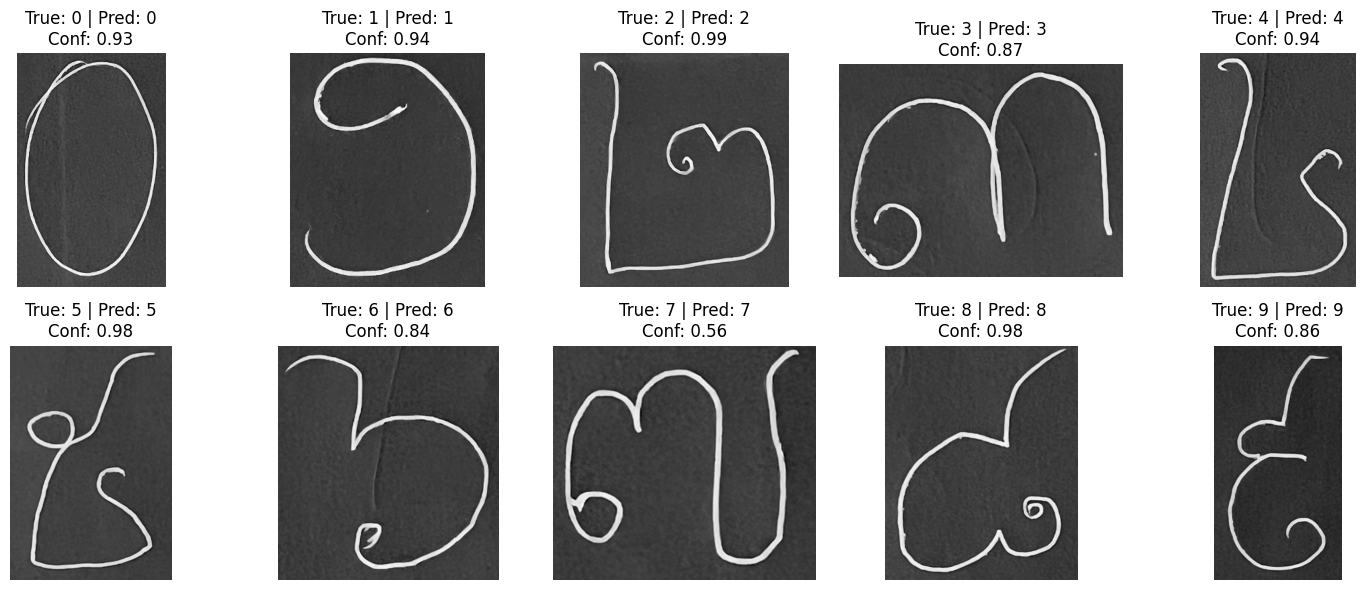

In [157]:
plt.figure(figsize=(15, 6))

idx = 1
for digit in range(10):
    class_dir = os.path.join(TEST_PATH, str(digit))
    img_name = os.listdir(class_dir)[0]
    img_path = os.path.join(class_dir, img_name)

    pred, _, conf = predict_one(img_path)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    plt.subplot(2, 5, idx)
    plt.imshow(img, cmap="gray")
    plt.title(
        f"True: {digit} | Pred: {pred}\nConf: {conf:.2f}"
    )
    plt.axis("off")

    idx += 1

plt.tight_layout()
plt.show()


**save model**

In [158]:
os.makedirs("../../models/lenet", exist_ok=True)
torch.save(model.state_dict(), "../../models/lenet/lenet.pth")

print("Model exported successfully!")

Model exported successfully!
